## 1. Environment Setup

### 1.1 Change Directory

Use jupyter magic command `%cd` to change the directory to the root directory of the project

In [12]:
%cd ../

/Users/joye/Github/datawhale_team_learning/projects/202301_image_classification


### 1.2 Install Packages

Install the packages with `pip`:
- `-r` means instaling from requirements.txt
- `-q` means installing quitely

In [35]:
!pip install -q -r requirements.txt

## 2. Download Images for Inference

In [115]:
%%bash
zhihao_asset="https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification"
data_dir="data/image_net"

curl $zhihao_asset/dataset/meta_data/imagenet_class_index.csv -o $data_dir/meta_data/class_index.csv --create-dirs 

curl $zhihao_asset/test/watermelon1.jpg -o $data_dir/test/watermelon1.jpg --create-dirs 
curl $zhihao_asset/test/banana1.jpg -o $data_dir/test/banana1.jpg --create-dirs 
curl $zhihao_asset/test/cat1.jpg -o $data_dir/test/cat1.jpg --create-dirs 

# husky，source: https://www.pexels.com/zh-cn/photo/2853130/
curl $zhihao_asset/test/husky1.jpeg -o $data_dir/test/husky1.jpeg --create-dirs 

# cat dog，来源：https://unsplash.com/photos/ouo1hbizWwo
curl $zhihao_asset/test/cat_dog.jpg -o $data_dir/test/cat_dog.jpg --create-dirs 

# video
curl $zhihao_asset/test/video_2.mp4 -o $data_dir/test/video_2.mp4 --create-dirs 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37074  100 37074    0     0  79010      0 --:--:-- --:--:-- --:--:-- 92223
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  419k  100  419k    0     0   857k      0 --:--:-- --:--:-- --:--:--  879k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  453k  100  453k    0     0   607k      0 --:--:-- --:--:-- --:--:--  621k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34701  100 34701    0     0  99304      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Tim

## 3. Inference using Pretrained Models

### 3.1 Load Packages and Setup Device

In [36]:
from torchvision import transforms


import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Use GPU if it is available otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
avaliability = "available" if torch.cuda.is_available() else "unavailable"
print(f'GPU is {avaliability} thus using {device.type.upper()}')

# sets the backend of matplotlib to the 'inline' backend, 
# With this backend, the output of plotting commands is displayed 
# inline within frontends like the Jupyter notebook, directly below
# the code cell that produced it. 
# The resulting plots will then also be stored in the notebook document.
%matplotlib inline

GPU is unavailable thus using CPU


### 3.2 Load Pretrained Models

In [37]:
# Import model and pretrained weights
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained image classification models
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# set model to evaluation/inference status
model = model.eval()
# send move to device
model = model.to(device)

### 3.3 Image Preprocessing for Inference

In [38]:
# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                     ])
def preprocess(img_path):
    img_pil = Image.open(img_path)
    print("Before preprocess: ", np.array(img_pil).shape)
    preprocessed_img = test_transform(img_pil) 
    print("After preprocess: ", preprocessed_img.shape)
    return preprocessed_img

In [125]:
################################################
# parameter
################################################
img_path = 'data/image_net/test/banana1.jpg'
################################################

input_img = preprocess(img_path)

Before preprocess:  (820, 1094, 3)
After preprocess:  torch.Size([3, 224, 224])


### 3.4 Inference 

In [116]:
import torch.nn.functional as F

def inference(input_img):
    input_img = input_img.unsqueeze(0).to(device)
    pred_logits = model(input_img) # Model inference
    print("Run model inference and output logits. The shape is ->", 
          pred_logits.shape)
    # Apply softmax
    pred_softmax = F.softmax(pred_logits, dim=1)
    print("Apply softmax on the logits to get probability. The shape is ->", 
          pred_softmax.shape)
    return pred_softmax

In [117]:
pred_softmax = inference(input_img)

Run model inference and output logits. The shape is -> torch.Size([1, 1000])
Apply softmax on the logits to get probability. The shape is -> torch.Size([1, 1000])


### 3.5 Analysis on Infernce Results

In [78]:
def plot_class_probability(y, bar_label= False):
    plt.rcParams['font.family'] = 'Arial'
    plt.figure(figsize=(8,4))
    
    x = range(y.shape[0])
    ax = plt.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
    plt.ylim([0, 1.0]) # y axis
    
    if bar_label:
        plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

    plt.xlabel('Class', fontsize=10)
    plt.ylabel('Confidence', fontsize=10)
    plt.tick_params(labelsize=10) 
    plt.title(img_path, fontsize=15)
    plt.show()

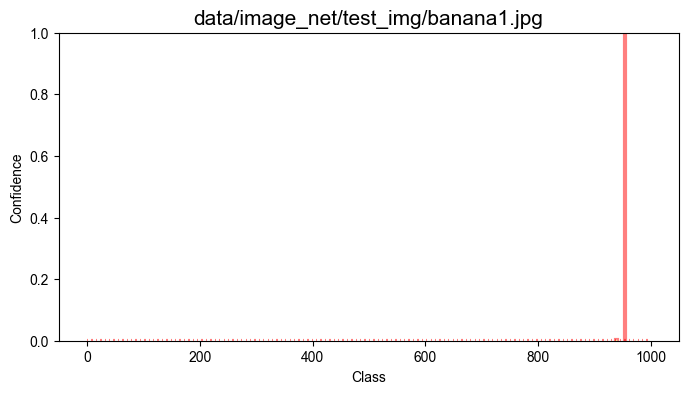

In [114]:
# Returns a copy of this object in CPU memory
y = pred_softmax.cpu().detach().numpy()[0] 
plot_class_probability(y)

In [145]:
def get_top_n(pred_softmax,n =10):
    top_n = torch.topk(pred_softmax, n)
    # get the id of top n
    pred_ids = top_n[1].cpu().detach().numpy().squeeze()
    # get the probablity of top n
    confs = top_n[0].cpu().detach().numpy().squeeze()
    return pred_ids, confs

def get_idx_labels(file_path):
    df = pd.read_csv(file_path)
    idx_to_labels = {}
    for idx, row in df.iterrows():
        idx_to_labels[row['ID']] = [row['wordnet'], row['class']]
    return idx_to_labels

def annotate_image(img_path, n,file_path=None):
    # use opencv to load the image
    img = cv2.imread(img_path)
    pred_ids, confs = get_top_n(pred_softmax,n)
    if file_path is None:
        file_path='data/image_net/meta_data/class_index.csv'
    idx_to_labels = get_idx_labels(file_path)
    for i in range(n):
        class_name = idx_to_labels[pred_ids[i]][1] # get name of the category 
        confidence = confs[i] * 100 # get probabiliy of the category
        text = '{:<15} {:>.4f}'.format(class_name, confidence)
        # annotate image on its left upper corner 
        # params: location，font，size，bgr color，line width
        img = cv2.putText(img, text, 
                          (25, 50 + 40 * i), 
                          cv2.FONT_HERSHEY_SIMPLEX,
                          1.25, 
                          (0, 0, 255),
                          3)
    return img 

In [146]:
annotated_img = annotate_image(img_path, n=10)
# save the image to output folder
_ = cv2.imwrite('output/img_pred.jpg', annotated_img)
# load the predicted image
img_pred = Image.open('output/img_pred.jpg')

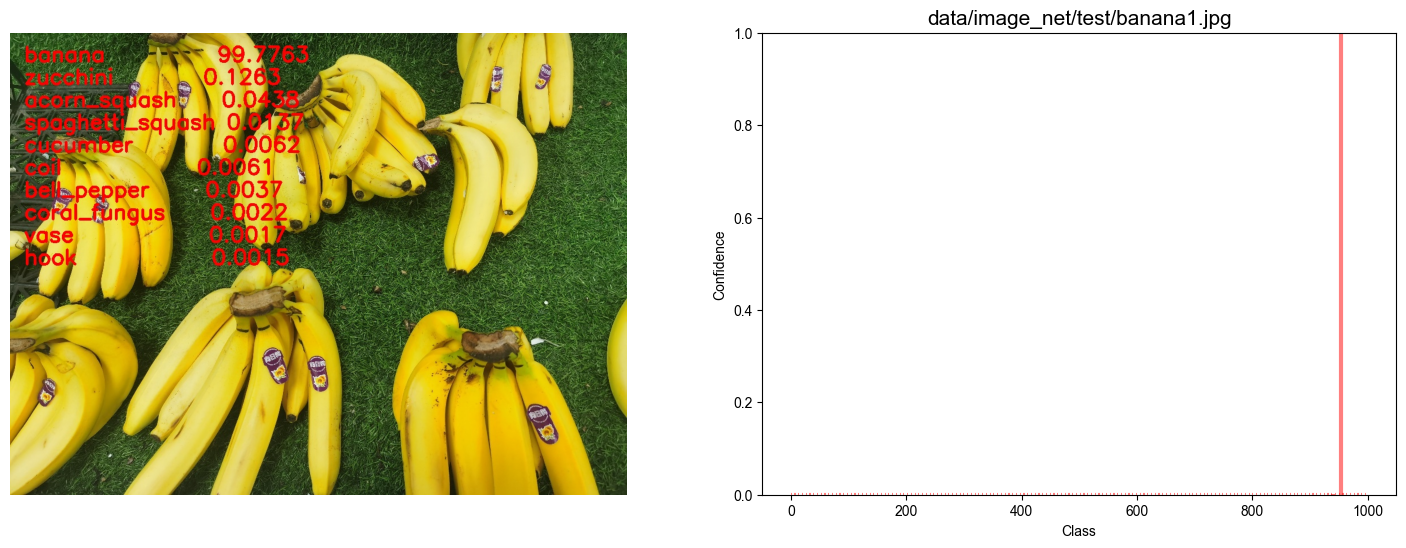

<Figure size 640x480 with 0 Axes>

In [143]:
fig = plt.figure(figsize=(18,6))

# 绘制左图-预测图
ax1 = plt.subplot(1,2,1)
ax1.imshow(img_pred)
ax1.axis('off')

# 绘制右图-柱状图
ax2 = plt.subplot(1,2,2)
file_path='data/image_net/meta_data/class_index.csv'
df =  pd.read_csv(file_path)
x = df['ID']
y = pred_softmax.cpu().detach().numpy()[0]
ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)

plt.ylim([0, 1.0]) # y轴取值范围
plt.title('{} Classification'.format(img_path), fontsize=30)
plt.xlabel('Class', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.tick_params(labelsize=10) 
plt.title(img_path, fontsize=15)
plt.show()

plt.tight_layout()
fig.savefig('output/预测图+柱状图.jpg')


In [161]:
pred_df = pd.DataFrame() # 预测结果表格
n = 10
idx_to_labels = get_idx_labels(file_path)
pred_ids, confs = get_top_n(pred_softmax,n)
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]][1] # 获取类别名称
    label_idx = int(pred_ids[i]) # 获取类别号
    wordnet = idx_to_labels[pred_ids[i]][0] # 获取 WordNet
    confidence = confs[i] * 100 # 获取置信度
    pred_df = pd.concat([pred_df,
                        pd.DataFrame([{'Class':class_name, 'Class_ID':label_idx,
                                      'Confidence(%)':confidence, 'WordNet':wordnet}])])
display(pred_df) # 展示预测结果表格

,Class,Class_ID,Confidence(%),WordNet
0,banana,954,99.776316,n07753592
0,zucchini,939,0.126272,n07716358
0,acorn_squash,941,0.043848,n07717410
0,spaghetti_squash,940,0.013670,n07716906
0,cucumber,943,0.006226,n07718472
0,coil,506,0.006063,n03065424
0,bell_pepper,945,0.003749,n07720875
0,coral_fungus,991,0.002227,n12985857
0,vase,883,0.001681,n04522168
0,hook,600,0.001548,n03532672
